In [1]:
options(warn = -1)
suppressMessages({
    library(Seurat)
    library(tidyverse)
    library(clusterProfiler)
    library(org.Mm.eg.db)
    library(VennDiagram)
    library(monocle)
})

In [2]:
# create outdir
if(!dir.exists("../results/SweetSeq_analysis_res/")){
    dir.create("../results/SweetSeq_analysis_res/01.clustering/",recursive = T)
    dir.create("../results/SweetSeq_analysis_res/02.tag_visualization/",recursive = T)
    dir.create("../results/SweetSeq_analysis_res/03.group_comparison_analysis_v1/",recursive = T)
    dir.create("../results/SweetSeq_analysis_res/04.group_comparison_analysis_v2/",recursive = T)
    dir.create("../results/SweetSeq_analysis_res/05.trajectory_analysis/",recursive = T)
}

[1] TRUE

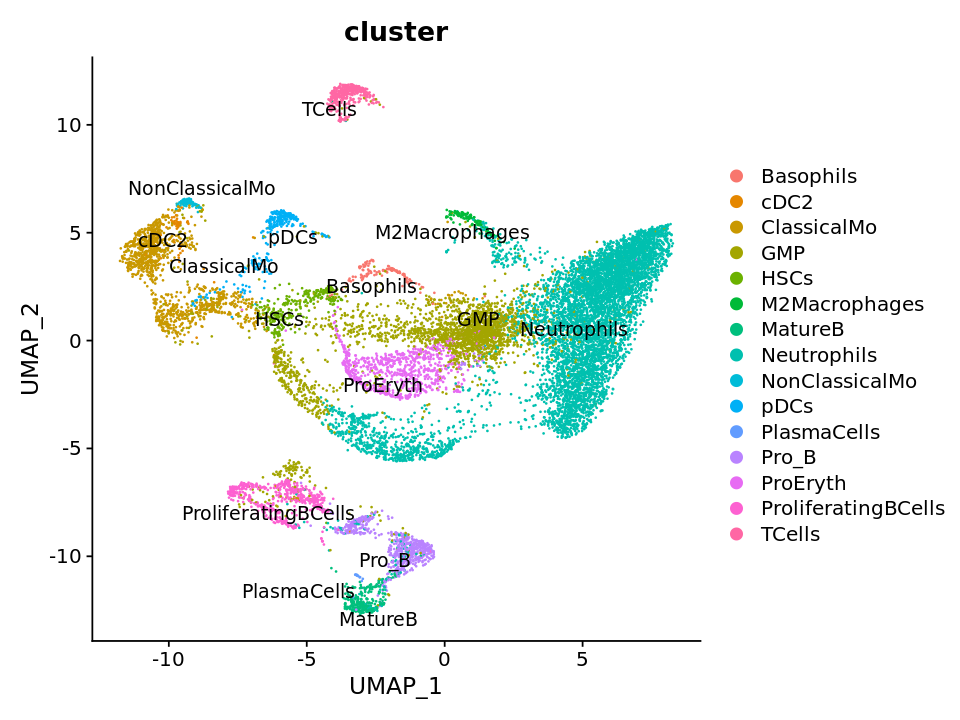

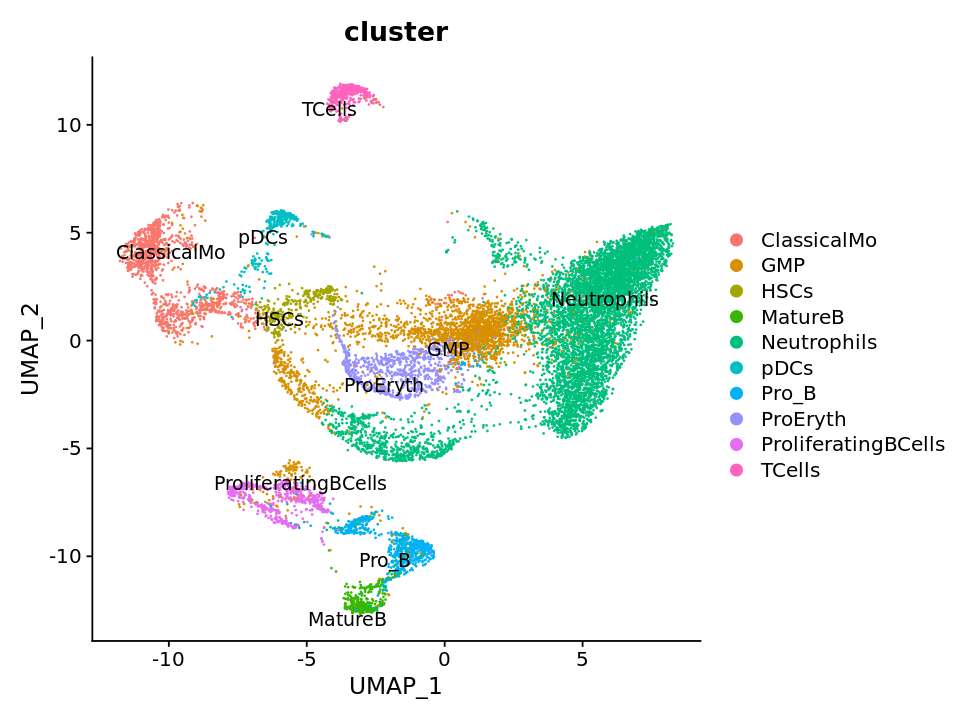

In [3]:
# Load rds (seurat object with cell annotations)
data_seurat <- readRDS("../data/FUT_Bonemarrow.rds")
sample_name <- unique(data_seurat$sample)
options(repr.plot.height=6 , repr.plot.width=8)
DimPlot(data_seurat, group.by = "cluster", label = T, repel = T)
ggsave("../results/SweetSeq_analysis_res/01.clustering/cluster_raw.png", height = 6, width = 8)

# Load sweet tag info
sweet_tag <- read.table("../data/mouse_BM/04.count_tag/umi_tag.tsv", sep="\t", header = T, row.names = 1)
sweet_tag$barcode <- paste0(sample_name, "_", row.names(sweet_tag))
row.names(sweet_tag) <- sweet_tag[,"barcode"]

sweet_tag <- sweet_tag[ colnames(data_seurat), ]
identical( row.names(sweet_tag), colnames(data_seurat))  
data_seurat$tag_UMI <- sweet_tag[,"sweet_tag"]
data_seurat$scaled_tag_UMI <- scale(log1p(data_seurat@meta.data[,"tag_UMI"]))
data_seurat$tag_UMI_group <- ifelse(data_seurat@meta.data[,"scaled_tag_UMI"] > 0, "tag_high","tag_low")

# select clusters with >300 cells for display
data_seurat <- subset(data_seurat, subset = cluster %in% names(table(data_seurat$cluster)[table(data_seurat@meta.data[,"cluster"]) > 300]))
DimPlot(data_seurat, group.by = "cluster", label = T, repel = T)
ggsave("../results/SweetSeq_analysis_res/01.clustering/cluster.png", height = 6, width = 8)

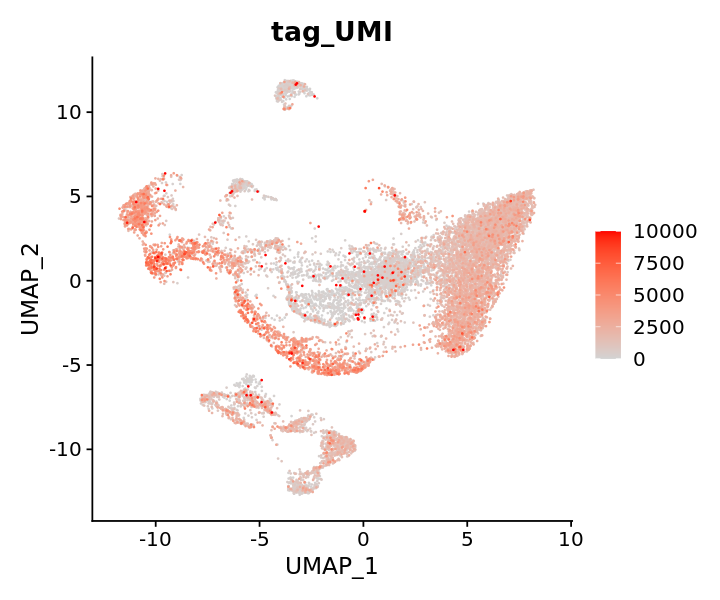

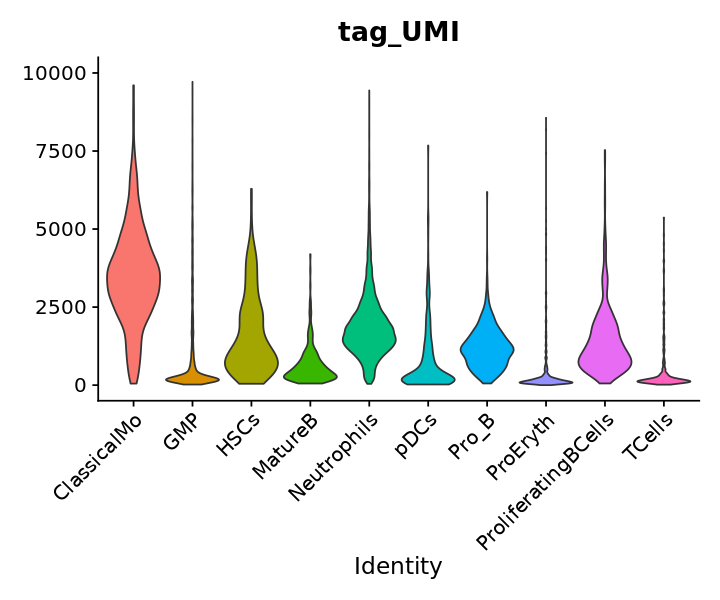

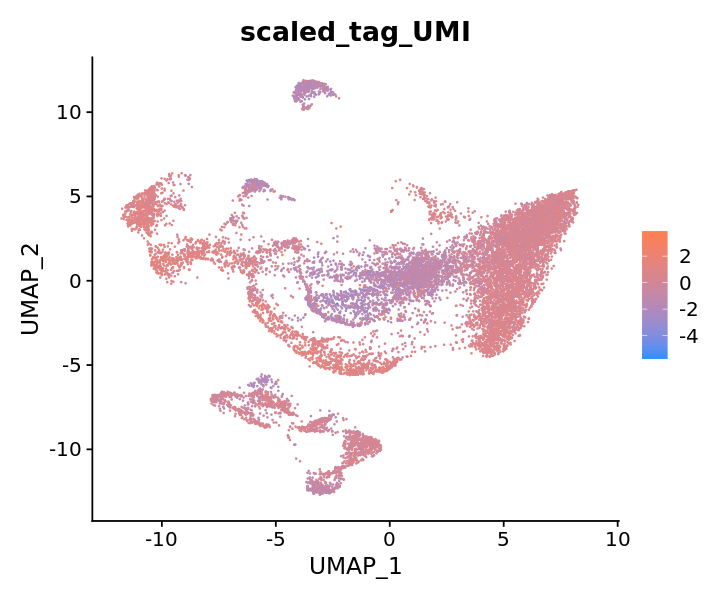

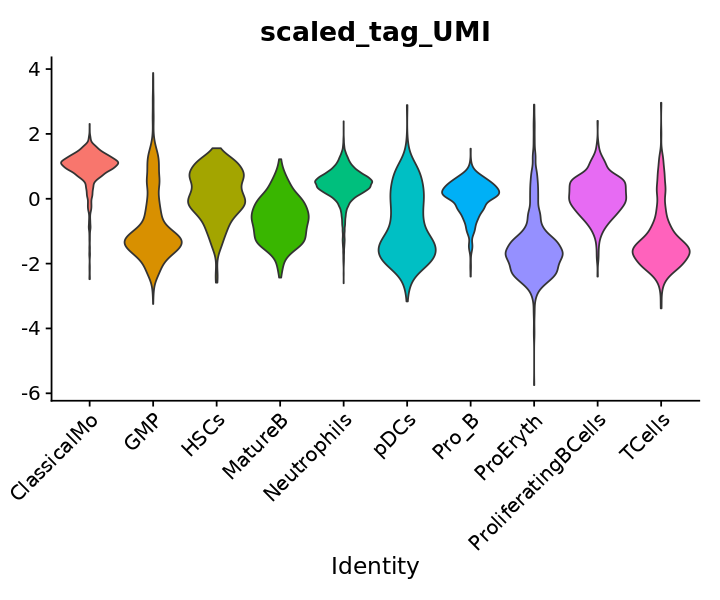

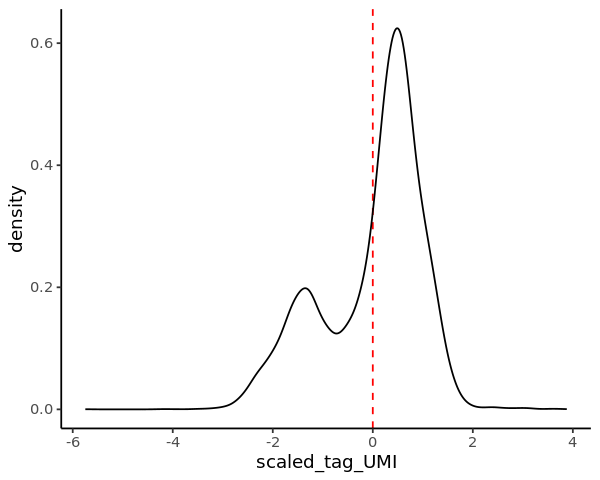

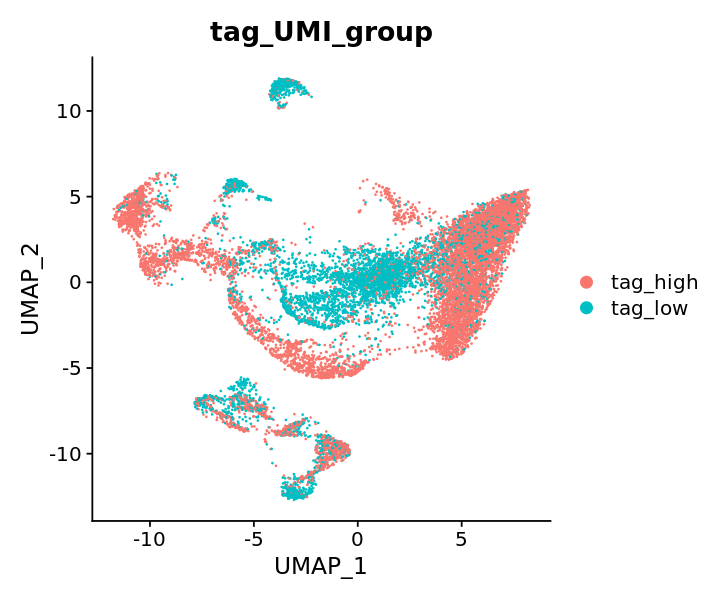

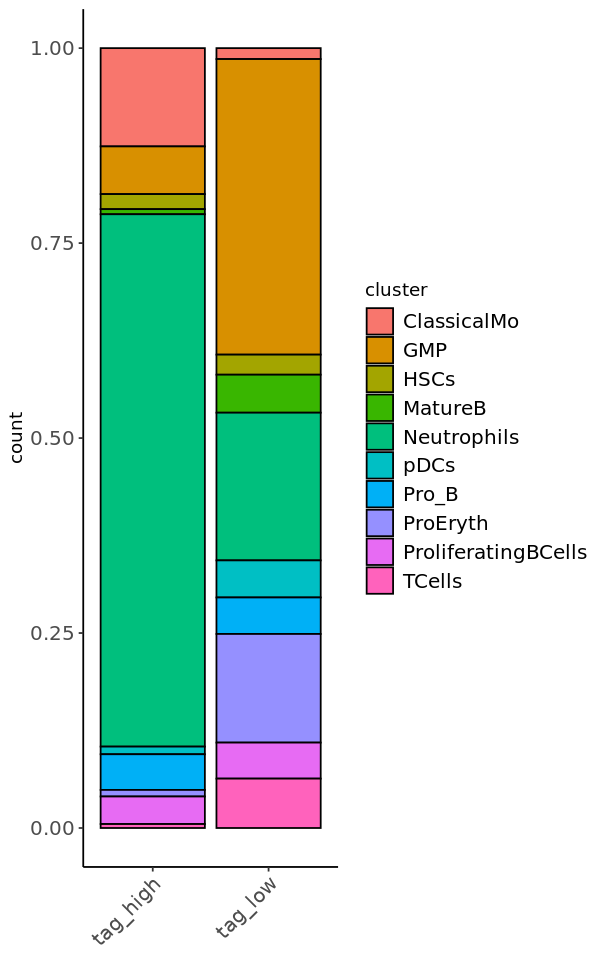

In [4]:
## 1 visualization of tags 
options(repr.plot.height=5 , repr.plot.width=6)
# raw value
FeaturePlot(data_seurat, features ="tag_UMI", cols = c('lightgrey','#FF0000'), order = T, max.cutoff = 10000) + ggtitle("tag_UMI")
ggsave("../results/SweetSeq_analysis_res/02.tag_visualization/tag_UMI_raw.png",height = 5, width = 6)
VlnPlot(data_seurat, features ='tag_UMI',group.by = "cluster", y.max = 10000, pt.size = 0) + NoLegend() + ggtitle("tag_UMI")
ggsave("../results/SweetSeq_analysis_res/02.tag_visualization/tag_UMI_raw_vlnplot.png", height = 5, width = 6)

# scaled value
FeaturePlot(data_seurat, features ="scaled_tag_UMI", cols =  c('#1E90FF','#FF7F50'),pt.size = 0.1) + ggtitle("scaled_tag_UMI")
ggsave("../results/SweetSeq_analysis_res/02.tag_visualization/tag_UMI_scaled.png",height = 5, width = 6)
VlnPlot(data_seurat, features ='scaled_tag_UMI',group.by = "cluster",pt.size = 0) + NoLegend() + ggtitle("scaled_tag_UMI")
ggsave("../results/SweetSeq_analysis_res/02.tag_visualization/tag_UMI_scaled_vlnplot.png", height = 5, width = 6)

# tag UMI density
options(repr.plot.height=4 , repr.plot.width=5)
data_seurat@meta.data %>%
    ggplot(aes(x = scaled_tag_UMI)) +
    geom_vline(xintercept = 0, color='red',linetype=2)+
    geom_density() + theme_classic()
ggsave("../results/SweetSeq_analysis_res/03.group_comparison_analysis_v1/tag_UMI_density.png", height = 4, width = 5)

# tag UMI group
options(repr.plot.height=5 , repr.plot.width=6)
DimPlot(data_seurat, group.by = "tag_UMI_group")
ggsave("../results/SweetSeq_analysis_res/03.group_comparison_analysis_v1/tag_UMI_group.png", height = 5, width = 6)

# tag UMI group component
options(repr.plot.height= 8, repr.plot.width = 5)
data_seurat@meta.data %>% 
    ggplot(aes(x = tag_UMI_group, fill = cluster)) +
    geom_bar(position = 'fill',color = 'black')+ 
    theme_classic()+
    theme(axis.text.x = element_text(angle = 45,hjust = 1,vjust = 1),legend.text = element_text(size=12),
          axis.text = element_text(size=12),axis.title.x = element_blank())
ggsave("../results/SweetSeq_analysis_res/03.group_comparison_analysis_v1/tag_UMI_group_component.png", height= 8, width = 5)

[1] "analyis cluster: Neutrophils"
[1] "cell number: 7022"
[1] "cell number of tag_high: 6050"
[1] "cell number of tag_low: 972"


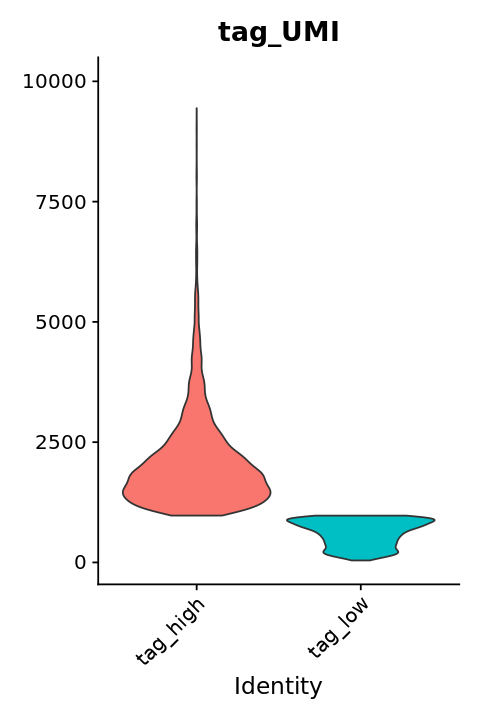

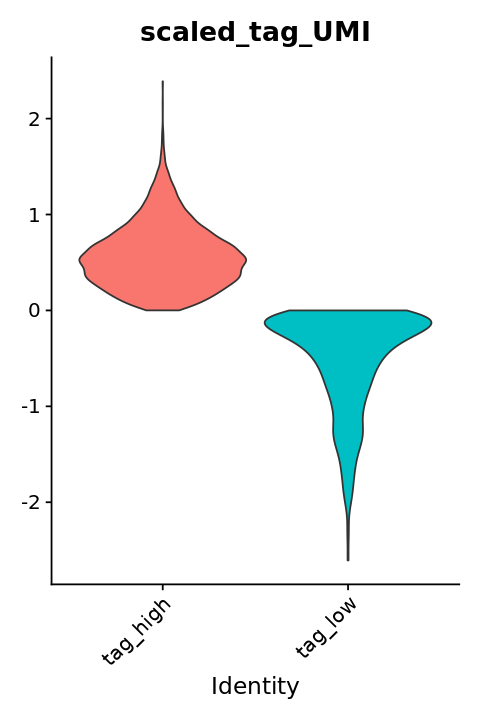

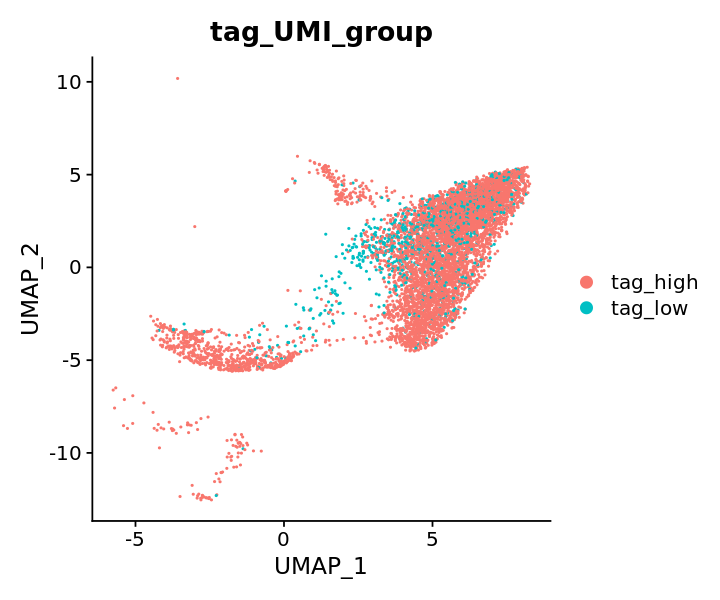

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for size is already present.
Adding another scale for size, which will replace the existing scale.


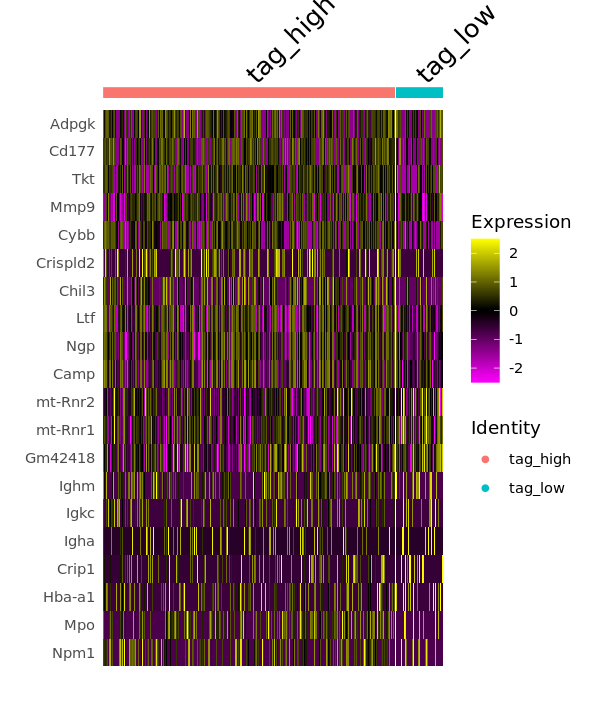

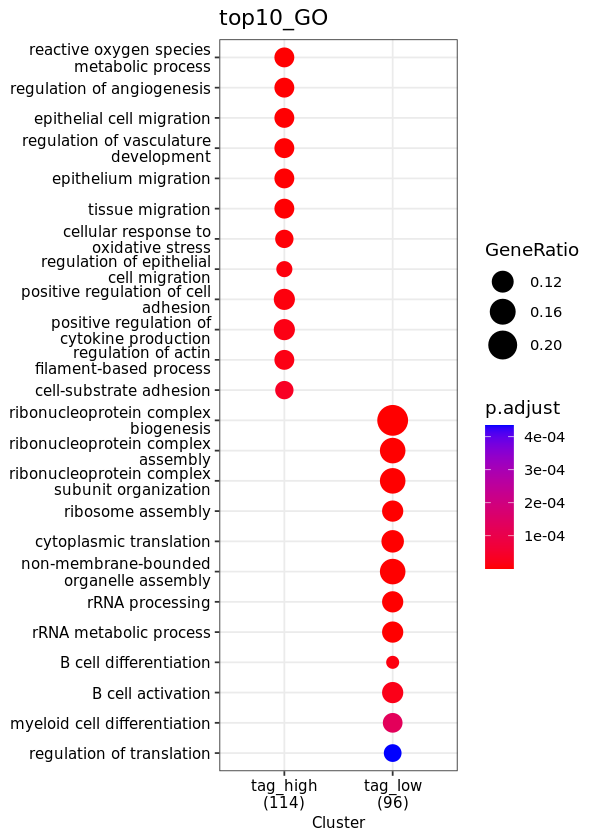

In [5]:
## 2 Comparison between high and low groups
# Grouping method V1
# Take Neutrophils as an axample
cluster_name <- "Neutrophils" 
data_Neutrophils <- subset(data_seurat, subset = cluster == cluster_name)
print(paste0("analyis cluster: ", cluster_name))
print(paste0("cell number: ", ncol(data_Neutrophils)))

data_Neutrophils$tag_UMI_group <- factor(data_Neutrophils@meta.data[,"tag_UMI_group"], levels = c('tag_high', 'tag_low'))
print(paste0("cell number of tag_high: ", sum(data_Neutrophils$tag_UMI_group == 'tag_high')))
print(paste0("cell number of tag_low: ", sum(data_Neutrophils$tag_UMI_group == 'tag_low')))

# tag between groups
options(repr.plot.height=6 , repr.plot.width=4)
VlnPlot(data_Neutrophils, features ='tag_UMI', group.by = "tag_UMI_group", y.max = 10000, pt.size = 0) + NoLegend() + ggtitle("tag_UMI")
ggsave("../results/SweetSeq_analysis_res/03.group_comparison_analysis_v1/tag_UMI_Neutrophils.png", height=6, width=4)
VlnPlot(data_Neutrophils, features ='scaled_tag_UMI', group.by = "tag_UMI_group", pt.size = 0) + NoLegend() + ggtitle("scaled_tag_UMI")
ggsave("../results/SweetSeq_analysis_res/03.group_comparison_analysis_v1/tag_UMI_scaled_Neutrophils.png", height=6, width=4)

options(repr.plot.height=5 , repr.plot.width=6)
DimPlot(data_Neutrophils, group.by = "tag_UMI_group")
ggsave("../results/SweetSeq_analysis_res/03.group_comparison_analysis_v1/tag_UMI_group_Neutrophils.png", height = 5, width = 6)

# FindMarkers
Idents(data_Neutrophils) <- data_Neutrophils@meta.data[,"tag_UMI_group"]
markers_Neutrophils <- FindAllMarkers(data_Neutrophils, only.pos = T, verbose = F)
markers_Neutrophils <- markers_Neutrophils[ markers_Neutrophils$p_val_adj < 0.05,]

# heatmap
data_plot <- ScaleData(data_Neutrophils, features = row.names(data_Neutrophils@assays$RNA@data), verbose = F) 
options(repr.plot.height=6, repr.plot.width=5)
DoHeatmap(object = data_plot,
          features = c(markers_Neutrophils %>% filter(cluster == "tag_high") %>%
                           top_n(n = 10, wt = avg_log2FC) %>%
                           dplyr::select(gene) %>% unlist() %>% as.character(), 
                       markers_Neutrophils %>% filter(cluster == "tag_low") %>% 
                           top_n(n = 10, wt = avg_log2FC) %>% 
                           dplyr::select(gene) %>% unlist() %>% as.character()))
ggsave("../results/SweetSeq_analysis_res/03.group_comparison_analysis_v1/degs_heatmap_Neutrophils.png", width = 6.5, height = 6)

# go enrichment
go_Neutrophils=compareCluster(geneCluster = split(markers_Neutrophils$gene, markers_Neutrophils[,"cluster"]), 
                  fun = "enrichGO",
                  keyType = "SYMBOL",
                  OrgDb = org.Mm.eg.db,
                  ont = "BP",
                  pAdjustMethod = "BH")
go_Neutrophils_sim <- simplify(go_Neutrophils, cutoff = 0.7, by = "p.adjust", select_fun = min)

options(repr.plot.height = 7 , repr.plot.width = 5)
p <- dotplot(go_Neutrophils_sim, font.size = 9, showCategory = 12, includeAll = TRUE, title = "top10_GO") + 
    scale_y_discrete(labels = function(x) {str_wrap(x, width = 90)}) +
    scale_size()
ggsave("../results/SweetSeq_analysis_res/03.group_comparison_analysis_v1/go_enrichment_Neutrophils.png",plot = p, width = 6, height = 5)

[1] "analyis cluster: Neutrophils"
[1] "cell number: 7022"


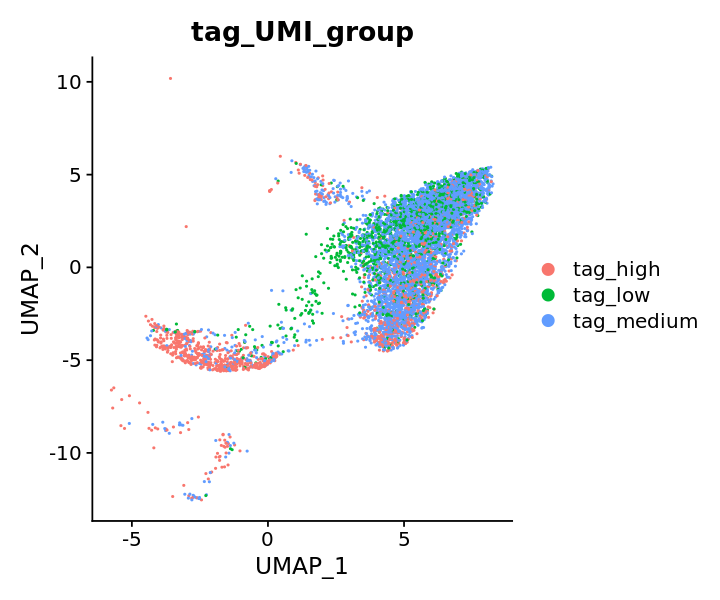

[1] "cell number of tag_high: 1404"
[1] "cell number of tag_low: 1404"


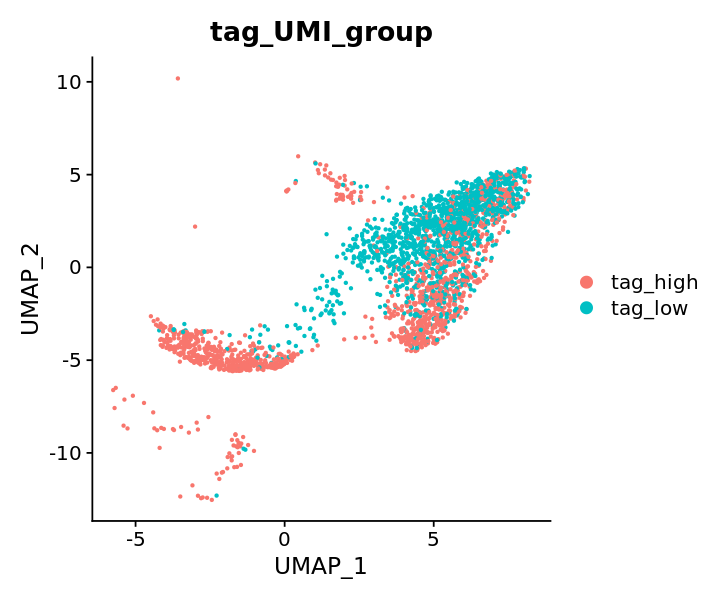

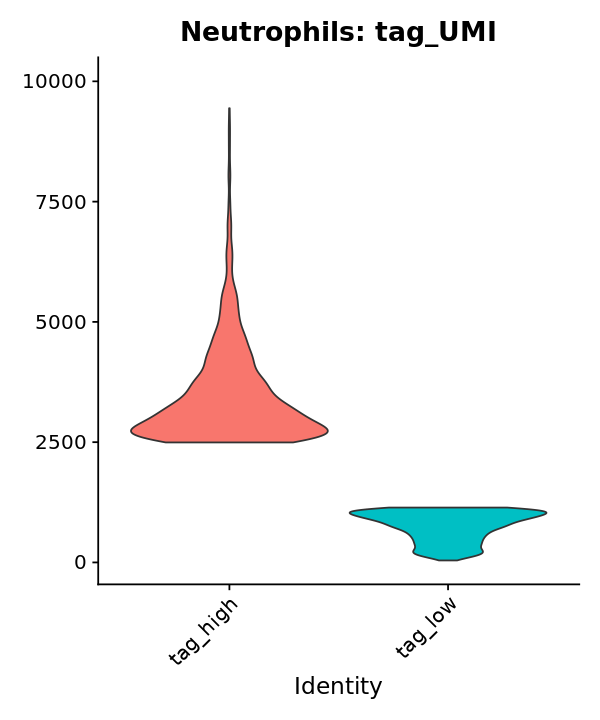

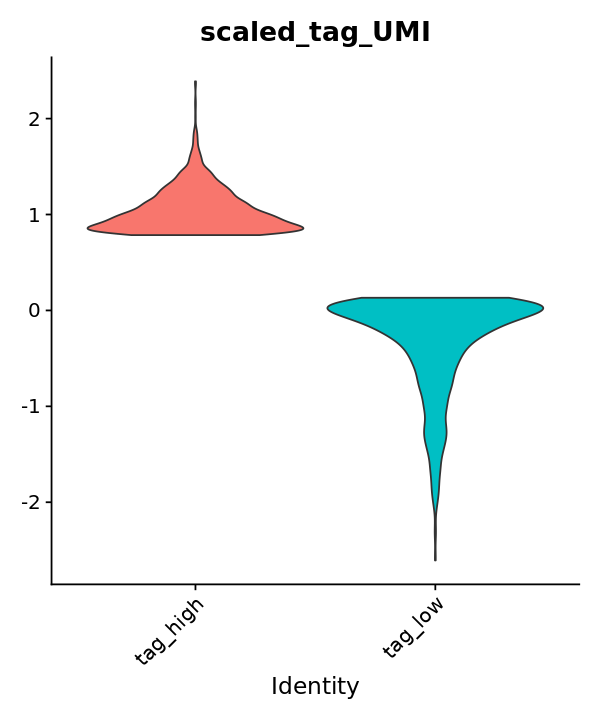

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for size is already present.
Adding another scale for size, which will replace the existing scale.


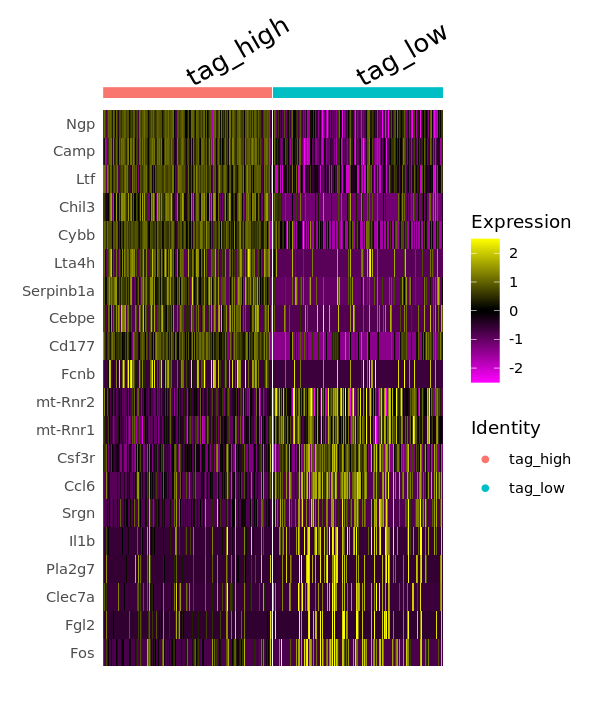

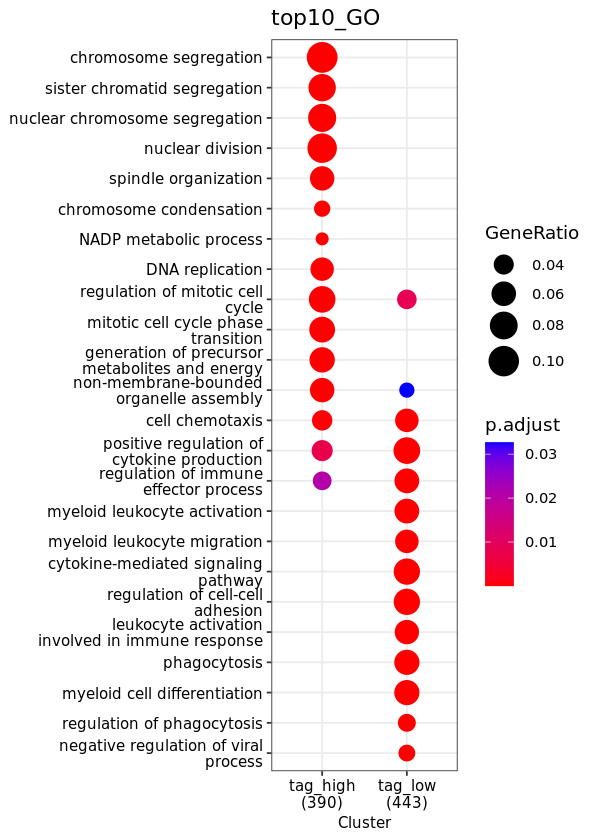

In [6]:
# Grouping method V2
# Take Neutrophils as an axample
cluster_name <- "Neutrophils" 
data_Neutrophils2 <- subset(data_seurat, subset = cluster == cluster_name)
print(paste0("analyis cluster: ", cluster_name))
print(paste0("cell number: ", ncol(data_Neutrophils2)))

function_set_sweet_group <- function(data, percent){
    group <- row.names(data@meta.data)
    high_barcode <- names(data$tag_UMI[order(data@meta.data[,"tag_UMI"], decreasing = T)][1:floor(ncol(data)*percent)])
    group[ group %in% high_barcode] = "tag_high"
    low_barcode <- names(data$tag_UMI[order(data@meta.data[,"tag_UMI"])][1:floor(ncol(data)*percent)])
    group[ group %in% low_barcode] = "tag_low"
    group[ !group %in% c("tag_high","tag_low")] = "tag_medium"
    return(group)
}
data_Neutrophils2$tag_UMI_group <- function_set_sweet_group(data_Neutrophils2, percent = 0.2)
options(repr.plot.height=5 , repr.plot.width=6)
DimPlot(data_Neutrophils2, group.by = "tag_UMI_group")
ggsave("../results/SweetSeq_analysis_res/04.group_comparison_analysis_v2/tag_UMI_group_Neutrophils2.png", height = 5, width = 6)

# select tag_high and tag_low
data_Neutrophils2 <- subset(data_Neutrophils2, subset = tag_UMI_group != "tag_medium")
data_Neutrophils2$tag_UMI_group <- factor(data_Neutrophils2@meta.data[,"tag_UMI_group"], levels = c('tag_high','tag_low'))
DimPlot(data_Neutrophils2, group.by = "tag_UMI_group")
ggsave("../results/SweetSeq_analysis_res/04.group_comparison_analysis_v2/tag_UMI_group_Neutrophils2_subset.png", height = 5, width = 6)

print(paste0("cell number of tag_high: ", sum(data_Neutrophils2$tag_UMI_group == 'tag_high')))
print(paste0("cell number of tag_low: ", sum(data_Neutrophils2$tag_UMI_group == 'tag_low')))

# tag between groups
options(repr.plot.height=6 , repr.plot.width=5)
VlnPlot(data_Neutrophils2, features ='tag_UMI',group.by = "tag_UMI_group", y.max = 10000, pt.size = 0) + NoLegend() + ggtitle(paste0(cluster_name,": tag_UMI"))
ggsave("../results/SweetSeq_analysis_res/04.group_comparison_analysis_v2/tag_UMI_Neutrophils2.png", height=6, width=4)

VlnPlot(data_Neutrophils2, features ='scaled_tag_UMI',group.by = "tag_UMI_group", pt.size = 0) + NoLegend() + ggtitle("scaled_tag_UMI")
ggsave("../results/SweetSeq_analysis_res/04.group_comparison_analysis_v2/tag_UMI_scaled_Neutrophils2.png", height=6, width=4)

# FindMarkers
Idents(data_Neutrophils2) <- data_Neutrophils2@meta.data[,'tag_UMI_group']
markers_Neutrophils2 <- FindAllMarkers(data_Neutrophils2, only.pos = T, verbose = F)
markers_Neutrophils2 <- markers_Neutrophils2[ markers_Neutrophils2$p_val_adj < 0.05,]

# heatmap
data_plot2 <- ScaleData(data_Neutrophils2, features = row.names(data_Neutrophils2@assays$RNA@data), verbose = F) 
options(repr.plot.height=6 , repr.plot.width=5)
DoHeatmap(object = data_plot2, angle = 30,
          features = c(markers_Neutrophils2 %>% filter(cluster == "tag_high") %>% 
                           top_n(n = 10, wt = avg_log2FC) %>% 
                           dplyr::select(gene) %>%
                           unlist() %>% as.character(), 
                       markers_Neutrophils2 %>% filter(cluster == "tag_low") %>%
                           top_n(n = 10, wt = avg_log2FC) %>%
                           dplyr::select(gene) %>%
                           unlist() %>% as.character()))
ggsave("../results/SweetSeq_analysis_res/04.group_comparison_analysis_v2/degs_heatmap_Neutrophils2.png", width = 6, height = 5)

# go enrichment
go_Neutrophils2=compareCluster(geneCluster = split(markers_Neutrophils2$gene, markers_Neutrophils2[,"cluster"]), 
                  fun = "enrichGO",
                  keyType = "SYMBOL",
                  OrgDb = org.Mm.eg.db,
                  ont = "BP",
                  pAdjustMethod = "BH")
go_Neutrophils2_sim <- simplify(go_Neutrophils2, cutoff= 0.7, by="p.adjust", select_fun=min)

options(repr.plot.height = 7 , repr.plot.width = 5)
p <- dotplot(go_Neutrophils2_sim, font.size = 9, showCategory = 12, includeAll = TRUE, title = "top10_GO") + 
    scale_y_discrete(labels = function(x) {str_wrap(x, width = 90)}) +
    scale_size()
ggsave("../results/SweetSeq_analysis_res/04.group_comparison_analysis_v2/go_enrichment_Neutrophils2.png",plot = p, width = 6, height = 5)

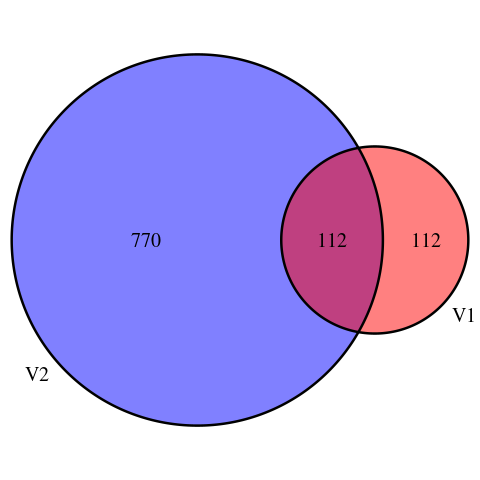

In [7]:
# venn of degs
options(repr.plot.height=4, repr.plot.width=4)
grid.draw(venn.diagram(list(V1 = markers_Neutrophils[,"gene"],
                            V2 = markers_Neutrophils2[,"gene"]), filename=NULL, fill=c('red','blue')))

Removing 96 outliers



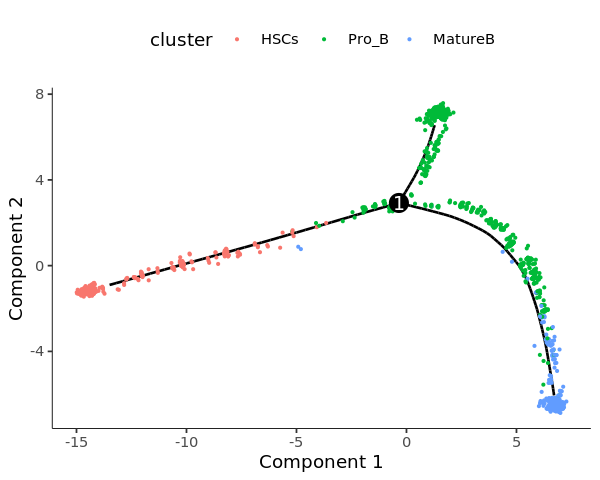

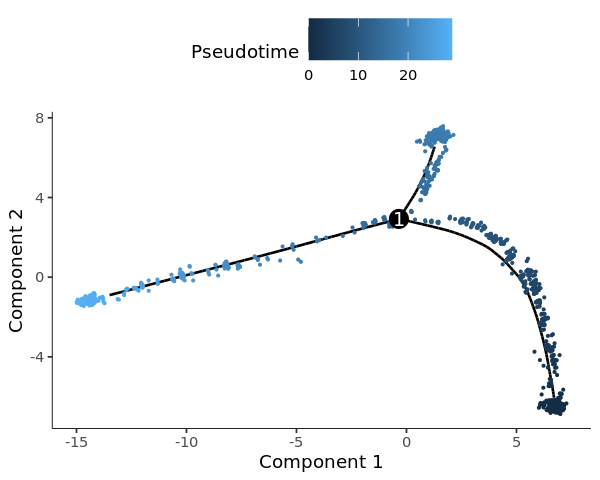

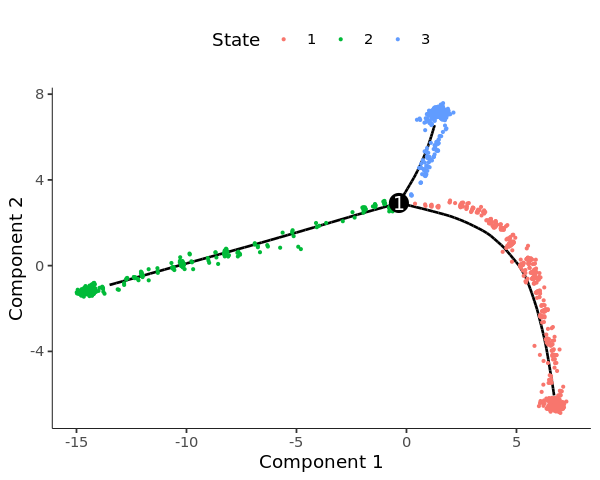

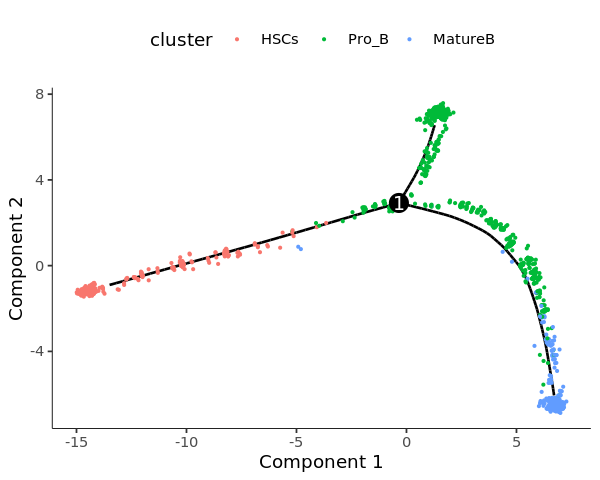

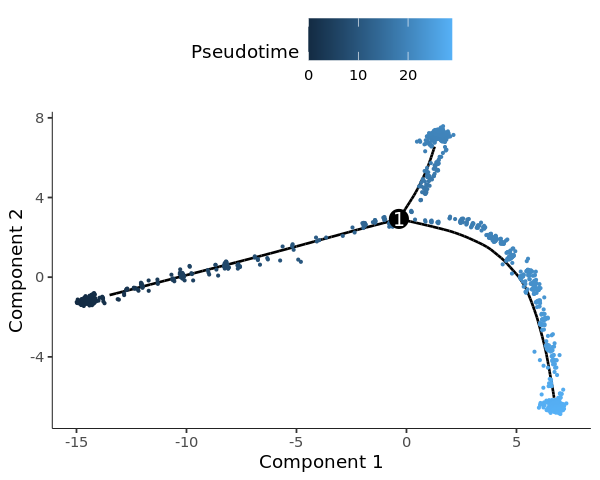

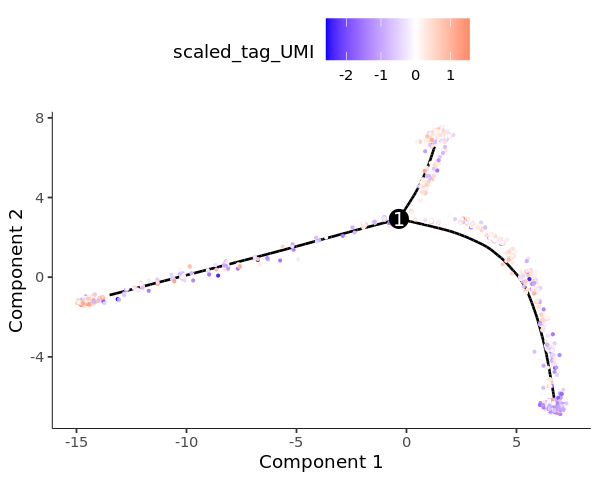

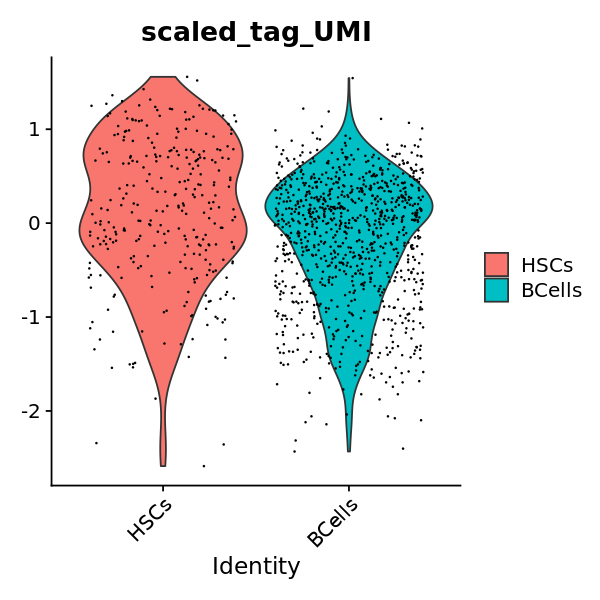

In [8]:
## 3 tag + trajectory analysis
# Take B-releated cells as an axample
data_B <- subset(data_seurat, subset = cluster %in% c('HSCs','Pro_B','MatureB'))
data_B$cluster <- factor(data_B@meta.data[,'cluster'], levels = c('HSCs','Pro_B','MatureB'))

pd <- new('AnnotatedDataFrame', data = data_B@meta.data)
fData <- data.frame(gene_short_name = row.names(data_B), row.names = row.names(data_B))
fd <- new('AnnotatedDataFrame', data = fData)
monocle_cds <- newCellDataSet(as(as.matrix(data_B@assays$RNA@counts), 'sparseMatrix'),
                              phenoData = pd,
                              featureData = fd,
                              lowerDetectionLimit = 0.1,
                              expressionFamily = negbinomial.size())
monocle_cds <- estimateSizeFactors(monocle_cds)
monocle_cds <- estimateDispersions(monocle_cds)
monocle_cds <- detectGenes(monocle_cds, min_expr = 0.1)   
expressed_genes <- row.names(subset(fData(monocle_cds),num_cells_expressed >= 10))
diff_test_res <- differentialGeneTest(monocle_cds[expressed_genes,],fullModelFormulaStr = "~cluster")
ordering_genes <- row.names (subset(diff_test_res, qval < 0.01))
monocle_cds <- setOrderingFilter(monocle_cds, ordering_genes)
monocle_cds <- reduceDimension(monocle_cds, max_components = 2,method = 'DDRTree')
monocle_cds <- orderCells(monocle_cds)
options(repr.plot.height=4, repr.plot.width=5)
plot_cell_trajectory(monocle_cds, color_by = "cluster",cell_size = 0.5)
plot_cell_trajectory(monocle_cds, color_by = "Pseudotime",cell_size = 0.5)
plot_cell_trajectory(monocle_cds, color_by = "State", cell_size = 0.5)
# set HSCs as root
monocle_cds <- orderCells(monocle_cds, root_state = 2)

plot_cell_trajectory(monocle_cds, color_by = "cluster",cell_size = 0.5)
ggsave("../results/SweetSeq_analysis_res/05.trajectory_analysis/monocle2_B_related_cluster.png",width = 3.5, height = 3)
plot_cell_trajectory(monocle_cds, color_by = "Pseudotime",cell_size = 0.5)
ggsave("../results/SweetSeq_analysis_res/05.trajectory_analysis/monocle2_B_related_pseudotime.png",width = 3.5, height = 3)
plot_cell_trajectory(monocle_cds, color_by = "scaled_tag_UMI",cell_size = 0.5)+ scale_color_gradient2(low = 'blue',high = 'red')
ggsave("../results/SweetSeq_analysis_res/05.trajectory_analysis/monocle2_B_related_scaled_tag_UMI.png",width = 3.5, height = 3)
options(repr.plot.height=5, repr.plot.width=5)
VlnPlot(data_B, features = 'scaled_tag_UMI')
ggsave("../results/SweetSeq_analysis_res/05.trajectory_analysis/vlnplot_B_related_scaled_tag_UMI.png",width = 5, height = 5)

In [9]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /SGRNJ01/Public/Software/conda_env/r4.1_env/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] splines   grid      stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] monocle_2.22.0        DDRTree_0.1.5         irlba_2.3.5.1        
 [4] VGAM_1.1-7            Matrix_1.5-3          VennDiagram_1.7.3    
 [7] futile.logger_1.4.3   org.Mm.eg.db_3.14.0   AnnotationDbi_1.56.2 
[10] IRanges_2.28.0        S4Vectors_0.32.4 